In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

import sys
import pandas as pd
import numpy as np
sys.path.insert(1, "../src")
sys.path.insert(1, "./utils")
import classifier
import classification_metrics

metadata_path = "/bigdisk/data/dataset/COVID19/covid-chest-xray/metadata.csv"
image_path = "/bigdisk/data/dataset/COVID19/covid-chest-xray/images/"
weights_path = "../model_weights/Chex+Cov/9cls_BCE_sigmoid_32.hdf5"

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
csv = pd.read_csv(metadata_path)

In [3]:
mod = list(csv['modality'])
print(set(mod))

mod = list(csv['view'])
print(set(mod))

mod = list(csv['finding'])
print(set(mod))

{'CT', 'X-ray'}
{'AP', 'AP semi erect', 'PA', 'Coronal', 'AP Supine', 'Axial', 'L'}
{'Klebsiella', 'E.Coli', 'Legionella', 'No Finding', 'Streptococcus', 'SARS', 'Chlamydophila', 'ARDS', 'COVID-19, ARDS', 'COVID-19', 'Pneumocystis'}


In [4]:
csv = csv[csv['modality'] == 'X-ray']
csv = csv[csv['view'].isin(['AP', 'AP semi erect', 'AP Supine', 'PA'])]

In [5]:
len(csv)

299

In [7]:
finding = list(csv['finding'])

In [8]:
desired = ['No Finding', 'COVID-19']

count = [0, 0]
for k in finding:
    if k in desired:
        count[desired.index(k)] += 1

In [9]:
count

[2, 232]

# Make a dataframe of desired format

In [10]:
def feature_string(row):
    desired = ['No Finding', 'COVID-19']#['No Finding', 'Pneumonia', 'Pneumonia/Viral/COVID-19']
    if row['finding'] in desired:
        if row['finding'] == 'Pneumonia/Viral/COVID-19':
            feature_string = "Covid"
        else:
            feature_string = row['finding']
    else:
        feature_string = ""
    return feature_string

csv['feature_string'] = csv.apply(feature_string,axis = 1).fillna('')
csv = csv[['filename', 'feature_string']]
csv['Path'] = csv['filename']

In [7]:
csv.to_pickle("./covid_ieee.pkl")

In [11]:
os.getcwd()
os.listdir("../model_weights/Chex+Cov/")

['9cls_BCE_sigmoid_32.hdf5']

# Evaluate

In [12]:
classifier_8 = classifier.Classifier(224, 1, 9)
classifier_8.datagen_init_valid_old(csv, image_path)
classifier_8.build_model(load_previous_weights=False, if_grad=False)
classifier_8.model.load_weights(weights_path)
classifier_8.model.output

Found 299 validated image filenames belonging to 3 classes.


 Pretrained weights Loaded




<tf.Tensor 'dense_3/Sigmoid:0' shape=(None, 9) dtype=float32>

In [13]:
## TEST IMG LOAD
import matplotlib.pyplot as plt

img1 = classifier_8.validation_generator[0//48][0][0%48]
path = csv['Path'][0]

In [26]:
from skimage.transform import resize

img2 = plt.imread(image_path+path)
print(img2.shape)
img2 = resize(img2, (224, 224))
print(img2.shape, np.unique(img2))

(888, 882, 3)
(224, 224, 3) [0.21290266 0.21462054 0.22578344 ... 0.97914259 0.98088235 0.98272059]


0.34836316489374225 7.596670403842154e-09


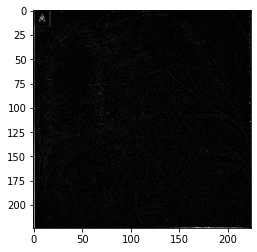

In [34]:
a = abs(img2 - img1)
print(np.amax(a), np.amin(a))
a = (a - np.amin(a)) / (np.amax(a) - np.amin(a))

plt.imshow(a)
plt.show()

In [15]:
y_pred_keras = classifier_8.model.predict_generator(classifier_8.validation_generator)

In [21]:
np.save("preds.npy", y_pred_keras)
np.save("labs.npy", y_labels)
y_pred_keras.shape, y_labels.shape

((548, 4), (548, 4))

In [16]:
y_labels_raw = classifier_8.validation_generator.labels
y_labels = np.zeros((len(classifier_8.validation_generator.labels), 4))
for ctr, k in enumerate(y_labels_raw):
    y_labels[ctr][k] += 1
classifier_8.validation_generator.class_indices

'''
{'': 0,
 'Atelectasis': 1,
 'Cardiomegaly': 2,
 'Consolidation': 3,
 'Covid': 4,
 'Edema': 5,
 'No Finding': 6,
 'Pleural Effusion': 7,
 'Pneumonia': 8}
'''
y_pred_keras = y_pred_keras[:, [0, 4, 6, 8]]

In [17]:
y_pred_keras.shape, y_labels.shape

((548, 4), (548, 4))

In [18]:
_classes = ["", "Covid", "No Finding", "Pneumonia"]#list(classifier_8.validation_generator.class_indices.keys())
_classes[0] = "Other"

ROC_AUCs, PR_AUCs, thresholds, fprs, tprs = classification_metrics.get_classification_metrics(y_labels, y_pred_keras)

In [19]:
# thresh = classification_metrics.get_thresholds(y_labels, y_pred_keras, thresholds=thresholds, tprs=tprs, 
#                    mode='max_fscore')
thresh = [0.12, 0.09, 0.8, 0.52]

sen, spec, pos, neg, fns, fps, confs = classification_metrics._classification_report(y_labels, y_pred_keras, thresh)

In [20]:
print(_classes)
print("Thr: ", thresh)
print("Sen: ", sen)
print("Spe: ", spec)
print("POS: ", pos)
print("FNs: ", fns)
print("NEG: ", neg)
print("FPs: ", fps)
for k in confs:
    print(k)

['Other', 'Covid', 'No Finding', 'Pneumonia']
Thr:  [0.12, 0.09, 0.8, 0.52]
Sen:  [0.06, 0.77, 0.2, 0.0]
Spe:  [0.9, 0.29, 0.93, 1.0]
POS:  [140.0, 342.0, 15.0, 51.0]
FNs:  [131.0, 80.0, 12.0, 51.0]
NEG:  [408.0, 206.0, 533.0, 497.0]
FPs:  [39.0, 146.0, 36.0, 0.0]
[[369  39]
 [131   9]]
[[ 60 146]
 [ 80 262]]
[[497  36]
 [ 12   3]]
[[497   0]
 [ 51   0]]
